# Imports

In [30]:
%autosave 60

#basic libraries: numpy and pandasfor data handling, pyplot 
#and seaborn for visualization, math for mathematical operations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import chi2_contingency


#dataset partition
from sklearn.model_selection import train_test_split

#feature selection methods
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import RFE
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

#scaling methods and categorical variable encoder
from sklearn.preprocessing import RobustScaler, OneHotEncoder

#model selection 
from sklearn import model_selection
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

#linear models
from sklearn.linear_model import LogisticRegression, SGDClassifier

#gaussian naive bayes
from sklearn.naive_bayes import GaussianNB

#decision tree classifier
from sklearn.tree import DecisionTreeClassifier

#k-neighbors classifier
from sklearn.neighbors import KNeighborsClassifier

#principal component analysis
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

#neural network
from sklearn.neural_network import MLPClassifier

#ensemble classifier models
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier, \
VotingClassifier, AdaBoostClassifier, StackingClassifier, HistGradientBoostingClassifier, \
ExtraTreesClassifier

#support vector machines
from sklearn.svm import SVC

#model evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
make_scorer, classification_report, confusion_matrix, f1_score

from itertools import combinations
from collections import Counter

Autosaving every 60 seconds


# Loading Data

In [31]:
#training data

original = pd.read_csv("train.csv")
dfRAW = original.copy()

In [32]:
#test data

test_df_original = pd.read_csv('test.csv')
test_df = test_df_original.copy()

In [33]:
dfRAW.head()

,Access_ID,Date,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor,Buy
0,102863333,21-Mar-20,0,0.0,0,0.0,3,64.0000,0.0000,0.0667,0.0000,MacOSX,2,Portugal,1,Returner,0
1,103117814,20-May-20,0,0.0,0,0.0,23,684.5000,0.0217,0.0449,0.0000,Windows,2,France,6,Returner,0
2,103201891,4-Dec-20,0,0.0,0,0.0,8,95.0000,0.0250,0.0583,0.0000,Windows,4,Italy,1,Returner,0
3,103226087,22-Dec-20,0,0.0,0,0.0,9,608.7500,0.0000,0.0250,42.4225,Windows,2,United Kingdom,2,Returner,1
4,103234445,24-Nov-20,0,0.0,2,386.0,36,1609.9397,0.0000,0.0093,12.5033,Windows,2,Spain,3,Returner,1


## Inital Data Exploration

**Information about the Data fields of our data**

Access_ID - Unique identification of the user access to the website  
Date - Website visit date  
AccountMng_Pages - Number of pages visited by the user about account management  
AccountMng_Duration - Total amount of time (seconds) spent by the user on account management related pages  
FAQ_Pages - Number of pages visited by the user about frequently asked questions, shipping information and company related pages  
FAQ_Duration - Total amount of time (seconds) spent by the user on FAQ pages  
Product_Pages - Number of pages visited by the user about products and services offered by the company  
Product_Duration - Total amount in time (seconds) spent by the user on products and services related pages  
GoogleAnalytics_BounceRate - Average bounce rate value of the pages visited by the user, provided by google analytics  
GoogleAnalytics_ExitRate - Average exit rate value of the pages visited by the user, provided by google analytics  
GoogleAnalytics_PageValue - Average page value of the pages visited by the user, provided by google analytics  
OS - Operating System of the user  
Browser - Browser used to access the webpage  
Country - The country of the user  
Type_of_Traffic - Traffic Source by which the user has accessed the website (e.g., email, banner, direct)  
Type_of_Visitor - User type as "New access", "Returner" or "Other"  
Buy - Class label indicating if the user finalized their actions in the website with a transaction  

In [34]:
# Change the data frame index to the access ID of each entry, rather than the standard index
dfRAW.set_index("Access_ID", inplace = True)

In [35]:
# Same for the test dataset
test_df.set_index("Access_ID", inplace = True)

In [36]:
# Change the format the date appears and the data type to datetime
dfRAW['Date'] = pd.to_datetime(dfRAW['Date'])

In [37]:
# Same for the test dataset
test_df['Date'] = pd.to_datetime(test_df['Date'])

In [38]:
#show the variables, their number of non-null values, and their data type
dfRAW.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9999 entries, 102863333 to 798444008
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        9999 non-null   datetime64[ns]
 1   AccountMng_Pages            9999 non-null   int64         
 2   AccountMng_Duration         9999 non-null   float64       
 3   FAQ_Pages                   9999 non-null   int64         
 4   FAQ_Duration                9999 non-null   float64       
 5   Product_Pages               9999 non-null   int64         
 6   Product_Duration            9999 non-null   float64       
 7   GoogleAnalytics_BounceRate  9999 non-null   float64       
 8   GoogleAnalytics_ExitRate    9999 non-null   float64       
 9   GoogleAnalytics_PageValue   9999 non-null   float64       
 10  OS                          9999 non-null   object        
 11  Browser                     9999 non-null  

In [39]:
# converting variables designed to be categorical into objects:
# "Browser" and "Type_of_Traffic" correspond to different 
# outcomes in numbers, so they're read as integer variables initially

dfRAW['Type_of_Traffic'] = dfRAW['Type_of_Traffic'].astype(object)
dfRAW['Browser'] = dfRAW['Browser'].astype(object)
test_df['Type_of_Traffic'] = test_df['Type_of_Traffic'].astype(object)
test_df['Browser'] = test_df['Browser'].astype(object)

# Exploratory Data Analysis

Check if there are any duplicated rows

In [40]:
dfRAW.duplicated().sum()

14

In [41]:
#Delete the duplicated rows
dfRAW.drop_duplicates(inplace = True)

In [42]:
#Now we have 0 duplicates, so the rows were deleted
dfRAW.duplicated().sum()

0

In [43]:
dfRAW.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9985 entries, 102863333 to 798444008
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        9985 non-null   datetime64[ns]
 1   AccountMng_Pages            9985 non-null   int64         
 2   AccountMng_Duration         9985 non-null   float64       
 3   FAQ_Pages                   9985 non-null   int64         
 4   FAQ_Duration                9985 non-null   float64       
 5   Product_Pages               9985 non-null   int64         
 6   Product_Duration            9985 non-null   float64       
 7   GoogleAnalytics_BounceRate  9985 non-null   float64       
 8   GoogleAnalytics_ExitRate    9985 non-null   float64       
 9   GoogleAnalytics_PageValue   9985 non-null   float64       
 10  OS                          9985 non-null   object        
 11  Browser                     9985 non-null  

In [44]:
#Note that at this point, Access_ID is already the index, so it does not count in the number of variables
print('This dataset has', dfRAW.shape[0], 'observations and', dfRAW.shape[1], 'variables')

This dataset has 9985 observations and 16 variables


In [45]:
#replacing empty string for np.nan so that we can count the missing values
dfRAW.replace(r'^\s*$', np.nan, inplace=True)

In [46]:
#there are no missing values
dfRAW.isna().sum()

Date                          0
AccountMng_Pages              0
AccountMng_Duration           0
FAQ_Pages                     0
FAQ_Duration                  0
Product_Pages                 0
Product_Duration              0
GoogleAnalytics_BounceRate    0
GoogleAnalytics_ExitRate      0
GoogleAnalytics_PageValue     0
OS                            0
Browser                       0
Country                       0
Type_of_Traffic               0
Type_of_Visitor               0
Buy                           0
dtype: int64

## Coherence Checks

In [47]:
#Check if there are years that do not fall out of the range (only 2020)
dfRAW['Date'].dt.year.value_counts()

2020    9985
Name: Date, dtype: int64

In [48]:
#Check if there are countries that do not have access to internet
dfRAW['Country'].value_counts()

Portugal          3859
Spain             1944
Brazil             946
France             923
Other              659
Italy              613
United Kingdom     428
Germany            350
Switzerland        263
Name: Country, dtype: int64

In [49]:
#Check the minimum value of the columns that are related to the pages visited or any duration, and confirm if the minimum is at least 0
dfRAW.describe(include="all").T['min']

Date                          NaN
AccountMng_Pages              0.0
AccountMng_Duration           0.0
FAQ_Pages                     0.0
FAQ_Duration                  0.0
Product_Pages                 0.0
Product_Duration              0.0
GoogleAnalytics_BounceRate    0.0
GoogleAnalytics_ExitRate      0.0
GoogleAnalytics_PageValue     0.0
OS                            NaN
Browser                       NaN
Country                       NaN
Type_of_Traffic               NaN
Type_of_Visitor               NaN
Buy                           0.0
Name: min, dtype: object

# Outliers

In [50]:
# Define metric and non-metric datasets
metric = dfRAW.drop(columns='Buy').select_dtypes(include=np.number)
non_metric = dfRAW.select_dtypes(exclude=np.number)

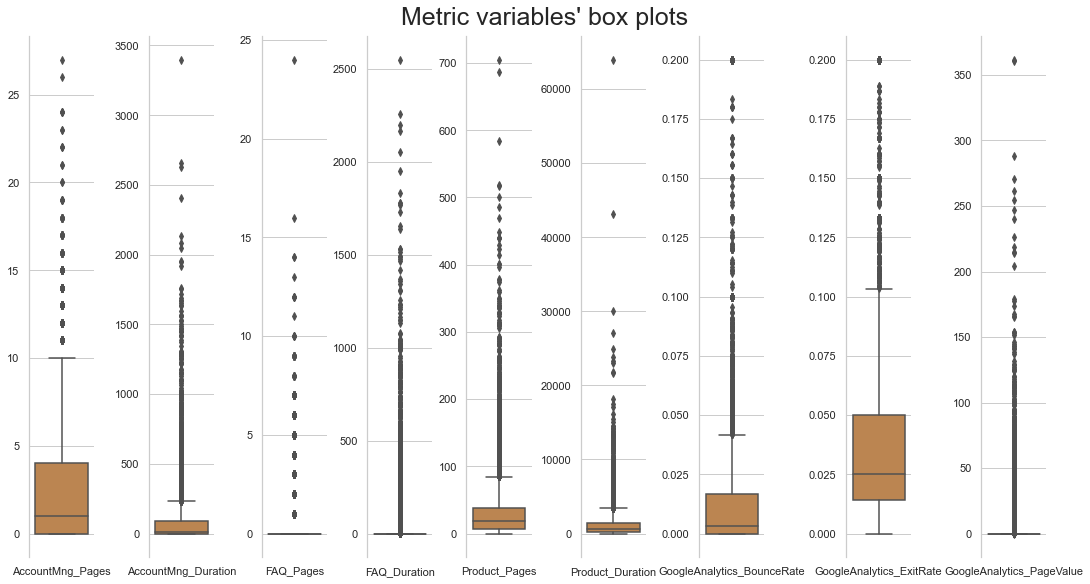

In [51]:
# Box plots for the metric variables
sns.set(style="whitegrid")

data = pd.melt(metric)
plot_features = metric.columns

#Prepare figure layout
fig, axes = plt.subplots(1, len(plot_features), figsize=(15,8), constrained_layout=True)
    
# Draw the boxplots
for i in zip(axes, plot_features):
    sns.boxplot(x="variable", y="value", data=data.loc[data["variable"]==i[1]], ax=i[0], color='peru')
    i[0].set_xlabel("")
    i[0].set_ylabel("")

# Finalize the plot
plt.suptitle("Metric variables' box plots", fontsize=25)
sns.despine(bottom=True)

plt.show()

In [52]:
# Check how many FAQ_Pages have received more than 15
dfRAW[dfRAW["FAQ_Pages"]>15] 

,Date,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor,Buy
Access_ID,,,,,,,,,,,,,,,,
223001153,2020-03-24,0,0.000,16,1210.3976,5,279.8571,0.0032,0.0128,0.0000,Windows,2,Portugal,8,Returner,0
543336544,2020-05-10,17,2629.254,24,2050.4333,705,43171.2334,0.0049,0.0154,0.7638,Windows,2,Portugal,14,Returner,0


In [53]:
# Check how many FAQ_Duration have received more than 2000
dfRAW[dfRAW["FAQ_Duration"]>2000] 

,Date,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor,Buy
Access_ID,,,,,,,,,,,,,,,,
345874652,2020-07-28,3,28.800,5,2195.3000,21,378.4000,0.0296,0.0309,0.0000,Android,1,Spain,1,Returner,0
354802585,2020-12-22,5,3398.750,6,2549.3750,449,63973.5222,0.0008,0.0277,0.0000,Windows,2,Portugal,2,Returner,0
497343934,2020-12-01,8,145.100,6,2166.5000,14,1805.4250,0.0000,0.0311,10.9002,iOS,5,Portugal,2,Returner,0
530514900,2020-12-16,4,367.000,5,2256.9167,74,8981.5801,0.0030,0.0433,0.0000,Windows,2,Portugal,8,Returner,0
543336544,2020-05-10,17,2629.254,24,2050.4333,705,43171.2334,0.0049,0.0154,0.7638,Windows,2,Portugal,14,Returner,0


In [54]:
# Check how many GoogleAnalytics_PageValue have received more than 275
dfRAW[dfRAW["GoogleAnalytics_PageValue"]>275] 

,Date,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor,Buy
Access_ID,,,,,,,,,,,,,,,,
160886320,2020-12-24,0,0.0,0,0.0,44,784.8833,0.0,0.0048,360.9534,Ubuntu,13,United Kingdom,15,Other,1
381524877,2020-11-23,3,37.5,0,0.0,18,607.5000,0.0,0.0105,361.7637,Windows,2,Spain,2,New_Access,1
637567537,2020-12-29,0,0.0,0,0.0,12,366.5000,0.0,0.0167,287.9538,Windows,2,Portugal,2,New_Access,1


In [55]:
obs_before_removal = dfRAW.shape[0]

In [56]:
# Manual removal of outliers by checking the box plots
filters = (
    (dfRAW['FAQ_Pages']<15)
    &
    (dfRAW['FAQ_Duration']<2000)
    &
    (dfRAW['GoogleAnalytics_PageValue']<200)
    &
    (dfRAW['Product_Pages']<550)
    &
    (dfRAW['Product_Duration']<35000)
    &
    (dfRAW['AccountMng_Pages']<25)
    &
    (dfRAW['AccountMng_Duration']<2500)
    #&
    #(dfRAW['GoogleAnalytics_ExitRate']<0.200)
    #&
    #(dfRAW['GoogleAnalytics_BounceRate']<0.200)

)

In [57]:
q25 = dfRAW.quantile(.25)
q75 = dfRAW.quantile(.75)
iqr = (q75 - q25)

upper_lim = q75 + 1.5 * iqr
lower_lim = q25 - 1.5 * iqr

iqr_filters = []
for metric in list(metric.columns):
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    iqr_filters.append(dfRAW[metric].between(llim, ulim, inclusive=True))

iqr_filters = pd.Series(np.all(iqr_filters, 0))

In [58]:
dfRAW_outl = dfRAW[(filters | iqr_filters)]
print(obs_before_removal)
print('Removed', obs_before_removal - dfRAW_outl.shape[0],'observations')
print('Proportion of data removed:', np.round(1 - dfRAW_outl.shape[0] / obs_before_removal, 4))

9985
Removed 23 observations
Proportion of data removed: 0.0023


In [59]:
print(round((1-len(dfRAW_outl)/len(dfRAW))*100,2),'% observations would be removed')

0.23 % observations would be removed


# Train-Test Split

Train and Validation:

In [60]:
data = dfRAW.iloc[:,:-1]
target = dfRAW.iloc[:,-1] #the target is the last column of the training data

In [61]:
#splitting the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data,
                                                  target,
                                                  test_size = 0.30,
                                                  random_state = 15,
                                                  shuffle=True,
                                                  stratify=target
)

In [62]:
df = pd.concat([X_train,y_train],axis=1) #full training set, target included

# Feature Engineering

In [63]:
df_val = pd.concat([X_val,y_val],axis=1)#full validation set, target included

In [64]:
#create feature Recency
df['Recency'] = pd.to_datetime(df['Date']).rsub(pd.Timestamp('now').floor('d')).dt.days
test_df['Recency'] = pd.to_datetime(test_df['Date']).rsub(pd.Timestamp('now').floor('d')).dt.days
df_val['Recency'] = pd.to_datetime(df_val['Date']).rsub(pd.Timestamp('now').floor('d')).dt.days

In [65]:
#create feature Month
df['Month'] = pd.DatetimeIndex(df['Date']).month.astype(object)
test_df['Month'] = pd.DatetimeIndex(test_df['Date']).month.astype(object)
df_val['Month'] = pd.DatetimeIndex(df_val['Date']).month.astype(object)

In [66]:
#create feature AccountMng_Duration_per_page
df['AccountMng_Duration_per_page'] = df['AccountMng_Duration']/df['AccountMng_Pages']
test_df['AccountMng_Duration_per_page'] = test_df['AccountMng_Duration']/test_df['AccountMng_Pages']
df_val['AccountMng_Duration_per_page'] = df_val['AccountMng_Duration']/df_val['AccountMng_Pages']

In [67]:
#create feature FAQ_Duration_per_page
df['FAQ_Duration_per_page'] = df['FAQ_Duration']/df['FAQ_Pages']
test_df['FAQ_Duration_per_page'] = test_df['FAQ_Duration']/test_df['FAQ_Pages']
df_val['FAQ_Duration_per_page'] = df_val['FAQ_Duration']/df_val['FAQ_Pages']

In [68]:
#create feature with day of the week
#0 - Monday, 6 - Sunday
df['Weekday'] = pd.to_datetime(df['Date']).dt.weekday.astype(object)
test_df['Weekday'] = pd.to_datetime(test_df['Date']).dt.weekday.astype(object)
df_val['Weekday'] = pd.to_datetime(df_val['Date']).dt.weekday.astype(object)

In [69]:
#delete feature Date because we already have Recency, Month and Weekday
del df['Date']
del test_df['Date']
del df_val['Date']

In [70]:
test_df

,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor,Recency,Month,AccountMng_Duration_per_page,FAQ_Duration_per_page,Weekday
Access_ID,,,,,,,,,,,,,,,,,,,
798519314,0,0.00,0,0.000,86,5332.5478,0.0139,0.0654,0.0000,Windows,2,Brazil,1,Returner,486,8,NaN,NaN,0
798663101,2,37.50,0,0.000,55,1420.4725,0.0012,0.0058,0.0000,Android,1,Spain,4,Returner,577,5,18.750000,NaN,0
798663221,0,0.00,0,0.000,36,788.5000,0.0000,0.0250,0.0000,Windows,6,Spain,3,Returner,416,11,NaN,NaN,0
798760918,0,0.00,0,0.000,2,689.0000,0.0000,0.1000,0.0000,Windows,2,Spain,2,New_Access,588,5,NaN,NaN,3
798856982,12,225.25,1,0.000,129,3367.0413,0.0014,0.0185,1.0353,Windows,4,Portugal,10,Returner,413,11,18.770833,0.0000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
962042726,10,720.50,2,88.725,220,10580.3448,0.0048,0.0221,0.0000,Windows,2,Portugal,1,Returner,391,11,72.050000,44.3625,4
962063064,0,0.00,0,0.000,3,55.0000,0.0667,0.1000,0.0000,MacOSX,2,Spain,3,Returner,643,3,NaN,NaN,4
962147749,2,45.50,0,0.000,22,535.0000,0.0000,0.0250,9.6503,Windows,2,Spain,11,Returner,396,11,22.750000,NaN,6


# Scaling

In [1]:
df_scaled = df.copy()
df_scaled_val = df_val.copy()
df_scaled_test = test_df.copy()

NameError: name 'df' is not defined

In [2]:
# Define metric and non-metric datasets
metric_features = df.drop(columns='Buy').select_dtypes(include=np.number).columns.to_list()
non_metric_features = df.select_dtypes(exclude=np.number).columns.to_list()

NameError: name 'df' is not defined

In [73]:
#scaling the train, validation, and test datasets with the robust scaler
scaler = RobustScaler()
scaled_feat = scaler.fit_transform(df_scaled[metric_features])
scaled_feat_val = scaler.fit_transform(df_scaled_val[metric_features])
scaled_feat_test = scaler.fit_transform(df_scaled_test[metric_features])

In [74]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6989 entries, 732444486 to 269187621
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   AccountMng_Pages              6989 non-null   int64  
 1   AccountMng_Duration           6989 non-null   float64
 2   FAQ_Pages                     6989 non-null   int64  
 3   FAQ_Duration                  6989 non-null   float64
 4   Product_Pages                 6989 non-null   int64  
 5   Product_Duration              6989 non-null   float64
 6   GoogleAnalytics_BounceRate    6989 non-null   float64
 7   GoogleAnalytics_ExitRate      6989 non-null   float64
 8   GoogleAnalytics_PageValue     6989 non-null   float64
 9   OS                            6989 non-null   object 
 10  Browser                       6989 non-null   object 
 11  Country                       6989 non-null   object 
 12  Type_of_Traffic               6989 non-null   obj

In [75]:
# putting the scaled versions of the metric features on the dataset for the scaled
df_scaled[metric_features] = scaled_feat
df_scaled_val[metric_features] = scaled_feat_val
df_scaled_test[metric_features] = scaled_feat_test

In [76]:
df_scaled.isna().sum()

AccountMng_Pages                   0
AccountMng_Duration                0
FAQ_Pages                          0
FAQ_Duration                       0
Product_Pages                      0
Product_Duration                   0
GoogleAnalytics_BounceRate         0
GoogleAnalytics_ExitRate           0
GoogleAnalytics_PageValue          0
OS                                 0
Browser                            0
Country                            0
Type_of_Traffic                    0
Type_of_Visitor                    0
Buy                                0
Recency                            0
Month                              0
AccountMng_Duration_per_page    3262
FAQ_Duration_per_page           5498
Weekday                            0
dtype: int64

In [77]:
df_scaled_val.isna().sum()

AccountMng_Pages                   0
AccountMng_Duration                0
FAQ_Pages                          0
FAQ_Duration                       0
Product_Pages                      0
Product_Duration                   0
GoogleAnalytics_BounceRate         0
GoogleAnalytics_ExitRate           0
GoogleAnalytics_PageValue          0
OS                                 0
Browser                            0
Country                            0
Type_of_Traffic                    0
Type_of_Visitor                    0
Buy                                0
Recency                            0
Month                              0
AccountMng_Duration_per_page    1396
FAQ_Duration_per_page           2342
Weekday                            0
dtype: int64

In [78]:
df_scaled_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2300 entries, 798519314 to 962218682
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   AccountMng_Pages              2300 non-null   float64
 1   AccountMng_Duration           2300 non-null   float64
 2   FAQ_Pages                     2300 non-null   float64
 3   FAQ_Duration                  2300 non-null   float64
 4   Product_Pages                 2300 non-null   float64
 5   Product_Duration              2300 non-null   float64
 6   GoogleAnalytics_BounceRate    2300 non-null   float64
 7   GoogleAnalytics_ExitRate      2300 non-null   float64
 8   GoogleAnalytics_PageValue     2300 non-null   float64
 9   OS                            2300 non-null   object 
 10  Browser                       2300 non-null   object 
 11  Country                       2300 non-null   object 
 12  Type_of_Traffic               2300 non-null   obj

In [79]:
df_scaled_test.isna().sum()

AccountMng_Pages                   0
AccountMng_Duration                0
FAQ_Pages                          0
FAQ_Duration                       0
Product_Pages                      0
Product_Duration                   0
GoogleAnalytics_BounceRate         0
GoogleAnalytics_ExitRate           0
GoogleAnalytics_PageValue          0
OS                                 0
Browser                            0
Country                            0
Type_of_Traffic                    0
Type_of_Visitor                    0
Recency                            0
Month                              0
AccountMng_Duration_per_page    1078
FAQ_Duration_per_page           1819
Weekday                            0
dtype: int64

In [80]:
#The NaN values result from dividing zero by zero while applying the robust scaler.
#Those values correspond to zero in reality, so they are replaced in the affected
#variables of the train, validation, and test scaled datasets.

df_scaled['AccountMng_Duration_per_page'] = df_scaled['AccountMng_Duration_per_page'].replace(np.nan, 0)
df_scaled['FAQ_Duration_per_page'] = df_scaled['FAQ_Duration_per_page'].replace(np.nan, 0)
df_scaled_val['AccountMng_Duration_per_page'] = df_scaled_val['AccountMng_Duration_per_page'].replace(np.nan, 0)
df_scaled_val['FAQ_Duration_per_page'] = df_scaled_val['FAQ_Duration_per_page'].replace(np.nan, 0)
df_scaled_test['AccountMng_Duration_per_page'] = df_scaled_val['AccountMng_Duration_per_page'].replace(np.nan, 0)
df_scaled_test['FAQ_Duration_per_page'] = df_scaled_val['FAQ_Duration_per_page'].replace(np.nan, 0)

In [81]:
df_scaled.isna().sum()

AccountMng_Pages                0
AccountMng_Duration             0
FAQ_Pages                       0
FAQ_Duration                    0
Product_Pages                   0
Product_Duration                0
GoogleAnalytics_BounceRate      0
GoogleAnalytics_ExitRate        0
GoogleAnalytics_PageValue       0
OS                              0
Browser                         0
Country                         0
Type_of_Traffic                 0
Type_of_Visitor                 0
Buy                             0
Recency                         0
Month                           0
AccountMng_Duration_per_page    0
FAQ_Duration_per_page           0
Weekday                         0
dtype: int64

In [82]:
df_scaled_val.isna().sum()

AccountMng_Pages                0
AccountMng_Duration             0
FAQ_Pages                       0
FAQ_Duration                    0
Product_Pages                   0
Product_Duration                0
GoogleAnalytics_BounceRate      0
GoogleAnalytics_ExitRate        0
GoogleAnalytics_PageValue       0
OS                              0
Browser                         0
Country                         0
Type_of_Traffic                 0
Type_of_Visitor                 0
Buy                             0
Recency                         0
Month                           0
AccountMng_Duration_per_page    0
FAQ_Duration_per_page           0
Weekday                         0
dtype: int64

In [83]:
df_scaled_val.isna().sum()

AccountMng_Pages                0
AccountMng_Duration             0
FAQ_Pages                       0
FAQ_Duration                    0
Product_Pages                   0
Product_Duration                0
GoogleAnalytics_BounceRate      0
GoogleAnalytics_ExitRate        0
GoogleAnalytics_PageValue       0
OS                              0
Browser                         0
Country                         0
Type_of_Traffic                 0
Type_of_Visitor                 0
Buy                             0
Recency                         0
Month                           0
AccountMng_Duration_per_page    0
FAQ_Duration_per_page           0
Weekday                         0
dtype: int64

# Feature Selection

## Feature Selection - Metric Features

In [84]:
data = df_scaled[metric_features]
target = df_scaled["Buy"]

In [85]:
#Correlation

In [86]:
def cor_heatmap(cor):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()

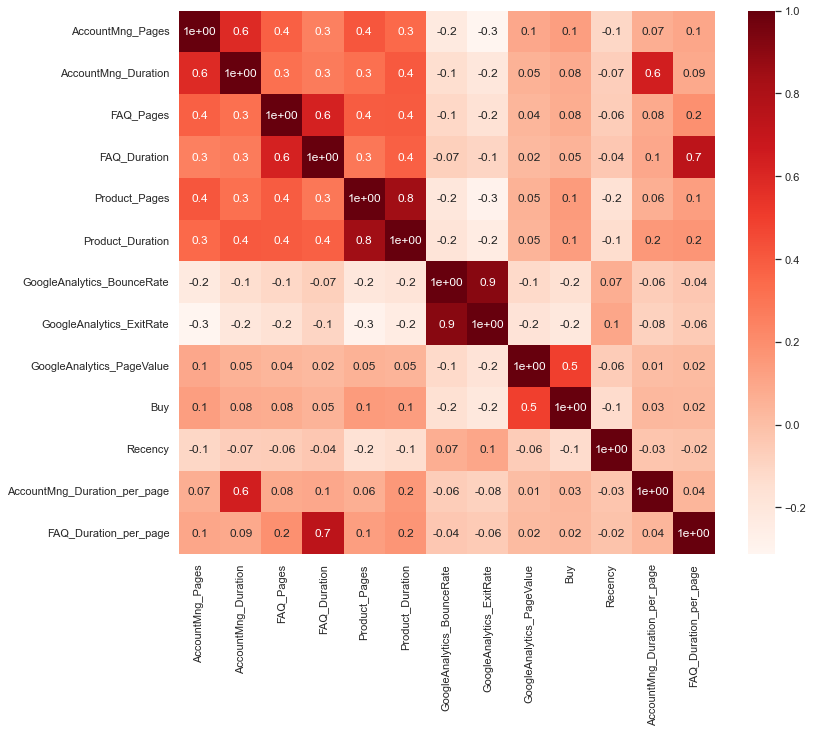

In [87]:
cor_heatmap(df_scaled.corr())

In [88]:
#RFE

In [89]:
#no of features
nof_list=np.arange(1,6)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]

#for each possible number of features
for n in range(len(nof_list)):
    #the data is split into training and test sets, with stratification
    X_train1, X_test1, y_train1, y_test1 = train_test_split(data,target, test_size = 0.3, random_state = 0, stratify = target)
    
    model = LogisticRegression()
    rfe = RFE(model,nof_list[n])
    
    #then the features are ranked and selected based on their importance to a logistic regression
    X_train_rfe = rfe.fit_transform(X_train1,y_train1)
    X_test_rfe = rfe.transform(X_test1)
    
    #the training partition with only the selected feature(s) is fit into a logistic regression
    model.fit(X_train_rfe,y_train1)
    
    #then the target is predicted for the test partition, and its accuracy evaluated
    #by its f1 score
    y_pred = model.predict(X_test_rfe)
    score = f1_score(y_test1, y_pred, average='micro')
    score_list.append(score)
    
    #the f1 score is saved in a list of scores, and the high score
    #and corresponding number of features are isolated
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
        
#The optimum number of features and the corresponding score is printed
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 4
Score with 4 features: 0.876967


In [90]:
#RFE selects 4 features according to a logistic regression
rfe = RFE(estimator = model, n_features_to_select = 4)
X_rfe = rfe.fit_transform(X = data, y = target)
model = LogisticRegression().fit(X = X_rfe,y = target)
selected_features = pd.Series(rfe.support_, index = data.columns)

# Features selected with RFE
selected_features

AccountMng_Pages                False
AccountMng_Duration             False
FAQ_Pages                       False
FAQ_Duration                    False
Product_Pages                    True
Product_Duration                False
GoogleAnalytics_BounceRate       True
GoogleAnalytics_ExitRate         True
GoogleAnalytics_PageValue       False
Recency                          True
AccountMng_Duration_per_page    False
FAQ_Duration_per_page           False
dtype: bool

In [91]:
#LASSO

Best alpha using built-in LassoCV: 0.003411
Best score using built-in LassoCV: 0.274667
Lasso picked 9 variables and eliminated the other 3 variables


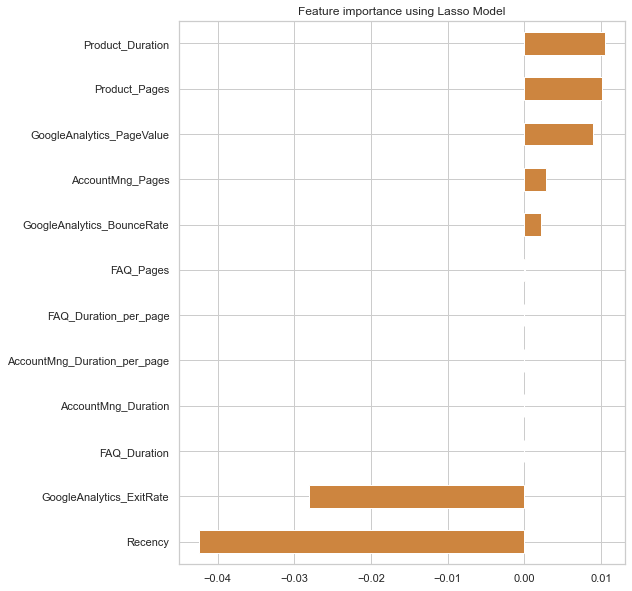

In [92]:
#barh plot created to show feature importance
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh", color="peru")
    plt.title("Feature importance using " + name + " Model")
    plt.show()
    
reg = LassoCV()

#the best alpha, best score, and feature importance plot determined
#using LASSO are shown
reg.fit(X=data, y=target)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X = data,y = target))
coef = pd.Series(reg.coef_, index = data.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
plot_importance(coef,'Lasso')

#### Sequential Forward Selection (SFS)

In [93]:
model = LogisticRegression()

In [94]:
# Stop when all features have been selected
forward = SFS(model, k_features=12, forward=True, scoring="accuracy", cv = None)

forward.fit(data, target)

SequentialFeatureSelector(cv=None, estimator=LogisticRegression(),
                          k_features=12, scoring='accuracy')

In [95]:
# Checking the features added at each step
forward_table = pd.DataFrame.from_dict(forward.get_metric_dict()).T.drop(columns=['cv_scores', 'ci_bound', 'std_dev', 'std_err'])
forward_table

,feature_idx,avg_score,feature_names
1,"(8,)",0.885105,"(GoogleAnalytics_PageValue,)"
2,"(3, 8)",0.885248,"(FAQ_Duration, GoogleAnalytics_PageValue)"
3,"(3, 7, 8)",0.884819,"(FAQ_Duration, GoogleAnalytics_ExitRate, Googl..."
4,"(3, 7, 8, 9)",0.88625,"(FAQ_Duration, GoogleAnalytics_ExitRate, Googl..."
5,"(1, 3, 7, 8, 9)",0.886393,"(AccountMng_Duration, FAQ_Duration, GoogleAnal..."
6,"(1, 3, 6, 7, 8, 9)",0.886822,"(AccountMng_Duration, FAQ_Duration, GoogleAnal..."
7,"(1, 3, 6, 7, 8, 9, 10)",0.886393,"(AccountMng_Duration, FAQ_Duration, GoogleAnal..."
8,"(0, 1, 3, 6, 7, 8, 9, 10)",0.88625,"(AccountMng_Pages, AccountMng_Duration, FAQ_Du..."
9,"(0, 1, 2, 3, 6, 7, 8, 9, 10)",0.885248,"(AccountMng_Pages, AccountMng_Duration, FAQ_Pa..."
10,"(0, 1, 2, 3, 6, 7, 8, 9, 10, 11)",0.885105,"(AccountMng_Pages, AccountMng_Duration, FAQ_Pa..."


In [96]:
# Iteration with the highest score
forward_table_max = forward_table['avg_score'].max()
forward_table_max

0.8868221490914294

In [97]:
# Feature's names
forward_table[forward_table['avg_score']==forward_table_max]['feature_names'].values

array([('AccountMng_Duration', 'FAQ_Duration', 'GoogleAnalytics_BounceRate', 'GoogleAnalytics_ExitRate', 'GoogleAnalytics_PageValue', 'Recency')],
      dtype=object)

#### Sequential Backward Selection (SBS)

In [98]:
# Stop when only one feature remains
backward = SFS(model, k_features=1, forward=False, scoring="accuracy", cv = None)

backward.fit(data, target)

SequentialFeatureSelector(cv=None, estimator=LogisticRegression(),
                          forward=False, scoring='accuracy')

In [99]:
# Checking the features removed at each step
backward_table = pd.DataFrame.from_dict(backward.get_metric_dict()).T.drop(columns=['cv_scores', 'ci_bound', 'std_dev', 'std_err'])
backward_table

,feature_idx,avg_score,feature_names
12,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)",0.884247,"(AccountMng_Pages, AccountMng_Duration, FAQ_Pa..."
11,"(0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11)",0.884819,"(AccountMng_Pages, AccountMng_Duration, FAQ_Pa..."
10,"(0, 1, 2, 3, 4, 6, 7, 8, 9, 11)",0.885391,"(AccountMng_Pages, AccountMng_Duration, FAQ_Pa..."
9,"(0, 1, 2, 3, 6, 7, 8, 9, 11)",0.885248,"(AccountMng_Pages, AccountMng_Duration, FAQ_Pa..."
8,"(1, 2, 3, 6, 7, 8, 9, 11)",0.886107,"(AccountMng_Duration, FAQ_Pages, FAQ_Duration,..."
7,"(2, 3, 6, 7, 8, 9, 11)",0.886393,"(FAQ_Pages, FAQ_Duration, GoogleAnalytics_Boun..."
6,"(2, 3, 6, 7, 8, 9)",0.886107,"(FAQ_Pages, FAQ_Duration, GoogleAnalytics_Boun..."
5,"(3, 6, 7, 8, 9)",0.886393,"(FAQ_Duration, GoogleAnalytics_BounceRate, Goo..."
4,"(6, 7, 8, 9)",0.886393,"(GoogleAnalytics_BounceRate, GoogleAnalytics_E..."
3,"(7, 8, 9)",0.886107,"(GoogleAnalytics_ExitRate, GoogleAnalytics_Pag..."


In [100]:
# Iteration with the highest score
backward_table_max = backward_table['avg_score'].max()
backward_table_max

0.8863929031334955

In [101]:
# Feature's names
backward_table[backward_table['avg_score']==backward_table_max]['feature_names'].values

array([('FAQ_Pages', 'FAQ_Duration', 'GoogleAnalytics_BounceRate', 'GoogleAnalytics_ExitRate', 'GoogleAnalytics_PageValue', 'Recency', 'FAQ_Duration_per_page'),
       ('FAQ_Duration', 'GoogleAnalytics_BounceRate', 'GoogleAnalytics_ExitRate', 'GoogleAnalytics_PageValue', 'Recency'),
       ('GoogleAnalytics_BounceRate', 'GoogleAnalytics_ExitRate', 'GoogleAnalytics_PageValue', 'Recency')],
      dtype=object)

<hr>

### Numerical Data

| Predictor | RFE | Lasso |  SFS | SBS | Correlation | Include in the model?
| --- | --- | --- | --- |--- | --- | --- |
| AccountMng_Pages | Discard | Keep | Discard | Keep | Keep |  Keep
| AccountMng_Duration | Discard | Keep | Keep | Discard | Keep | Keep
| FAQ_Pages | Discard | Keep | Discard | Discard | Keep | Discard
| FAQ_Duration | Discard | Discard | Keep | Discard | Keep |Discard 
| Product_Pages | Keep | Keep | Discard | Discard | Keep | Keep
| Product_Duration | Discard | Keep | Discard | Discard | Discard | Discard
| GoogleAnalytics_BounceRate | Keep | Keep | Keep | Discard | Keep | Keep
| GoogleAnalytics_ExitRate | Keep | Keep | Keep | Keep | Discard | Keep
| GoogleAnalytics_PageValue | Discard | Keep | Keep | Keep | Keep | Keep
| Recency | Keep | Keep | Keep | Discard | Keep | Keep
| AccountMng_Duration_per_page | Discard | Keep | Discard | Discard | Discard | Discard
| FAQ_Duration_per_page | Discard | Keep | Keep | Discard | Discard | Discard

<hr>


In [102]:
#After analyzing all the feature selection processes, the following features are kept.
#The table shows that the feature "AccountMng_Pages" should be kept, but it's removed
#due to its very high correlation with the variable "AccountMng_Duration", which is
#also held as important enough to keep
selected_num = ['AccountMng_Duration', 'Product_Pages', 'GoogleAnalytics_BounceRate', 'GoogleAnalytics_ExitRate', 'GoogleAnalytics_PageValue', 'Recency'] 

## Feature Selection - Categorical Features

In [103]:
non_metric_features

['OS',
 'Browser',
 'Country',
 'Type_of_Traffic',
 'Type_of_Visitor',
 'Month',
 'Weekday']

In [104]:
non_metric_features_buy = non_metric_features + ['Buy']

In [105]:
df_cffs=df_scaled[non_metric_features_buy].astype(object).copy()
df_cffs

,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor,Month,Weekday,Buy
Access_ID,,,,,,,,
732444486,MacOSX,2,Brazil,10,Returner,3,6,0
667424813,Windows,2,Portugal,6,Returner,5,4,0
312331523,Windows,2,Brazil,2,New_Access,12,4,0
752986399,Windows,2,Other,2,Returner,3,4,0
231492716,Android,1,Portugal,2,Returner,10,4,0
...,...,...,...,...,...,...,...,...
569242295,MacOSX,2,Germany,4,Returner,5,6,0
353442009,Windows,2,Italy,3,Returner,11,2,1
330440404,Android,1,Portugal,2,New_Access,12,0,0


In [106]:
#The categorical features' importance is evaluated using the chi-squared test.
#If the test's contingency is below the standard alpha of 0.05, then the
#categorical feature is deemed important.
chi2_check = []
for feature in non_metric_features:
    if chi2_contingency(pd.crosstab(df_cffs['Buy'], df_cffs[feature]))[1] < 0.05:
        chi2_check.append('Important Feature')
    else:
        chi2_check.append('Not an Important Feature')
res = pd.DataFrame(data = [non_metric_features, chi2_check] 
             ).T 
res.columns = ['Column', 'Feature Importance']
res

,Column,Feature Importance
0,OS,Important Feature
1,Browser,Not an Important Feature
2,Country,Not an Important Feature
3,Type_of_Traffic,Important Feature
4,Type_of_Visitor,Important Feature
5,Month,Important Feature
6,Weekday,Not an Important Feature


In [107]:
selected_cat = ['OS', 'Type_of_Traffic', 'Type_of_Visitor', 'Month']

# One Hot Encoding (OHC)

In [108]:
#all of the selected features, numerical and categorical
selected = selected_cat + selected_num

In [109]:
df_scaled[selected]

,OS,Type_of_Traffic,Type_of_Visitor,Month,AccountMng_Duration,Product_Pages,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,Recency
Access_ID,,,,,,,,,,
732444486,MacOSX,10,Returner,3,-0.077263,-0.516129,-0.179641,0.690608,0.0000,0.776042
667424813,Windows,6,Returner,5,-0.077263,-0.483871,3.814371,2.071823,0.0000,0.312500
312331523,Windows,2,New_Access,12,0.295254,-0.387097,-0.179641,0.000000,0.0000,-0.781250
752986399,Windows,2,Returner,3,9.502457,3.838710,-0.179641,-0.549724,9.9302,0.640625
231492716,Android,2,Returner,10,-0.077263,0.774194,0.107784,-0.279006,0.0000,-0.380208
...,...,...,...,...,...,...,...,...,...,...
569242295,MacOSX,4,Returner,5,-0.077263,-0.483871,-0.179641,0.535912,0.0000,0.447917
353442009,Windows,3,Returner,11,1.987859,2.677419,-0.059880,-0.320442,3.9982,-0.552083
330440404,Android,2,New_Access,12,0.154525,-0.064516,-0.179641,-0.494475,0.0000,-0.760417


In [110]:
df_train = pd.concat([df_scaled[selected], target], axis =1)

In [111]:
df_val = df_scaled_val[selected + ['Buy']]

In [112]:
df_test = df_scaled_test[selected]

In [113]:
df_train

,OS,Type_of_Traffic,Type_of_Visitor,Month,AccountMng_Duration,Product_Pages,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,Recency,Buy
Access_ID,,,,,,,,,,,
732444486,MacOSX,10,Returner,3,-0.077263,-0.516129,-0.179641,0.690608,0.0000,0.776042,0
667424813,Windows,6,Returner,5,-0.077263,-0.483871,3.814371,2.071823,0.0000,0.312500,0
312331523,Windows,2,New_Access,12,0.295254,-0.387097,-0.179641,0.000000,0.0000,-0.781250,0
752986399,Windows,2,Returner,3,9.502457,3.838710,-0.179641,-0.549724,9.9302,0.640625,0
231492716,Android,2,Returner,10,-0.077263,0.774194,0.107784,-0.279006,0.0000,-0.380208,0
...,...,...,...,...,...,...,...,...,...,...,...
569242295,MacOSX,4,Returner,5,-0.077263,-0.483871,-0.179641,0.535912,0.0000,0.447917,0
353442009,Windows,3,Returner,11,1.987859,2.677419,-0.059880,-0.320442,3.9982,-0.552083,1
330440404,Android,2,New_Access,12,0.154525,-0.064516,-0.179641,-0.494475,0.0000,-0.760417,0


In [114]:
df_ohc = df_train.copy()
df_ohc_val = df_val.copy()
df_ohc_test = df_test.copy()

In [115]:
df_ohc.head()

,OS,Type_of_Traffic,Type_of_Visitor,Month,AccountMng_Duration,Product_Pages,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,Recency,Buy
Access_ID,,,,,,,,,,,
732444486,MacOSX,10,Returner,3,-0.077263,-0.516129,-0.179641,0.690608,0.0000,0.776042,0
667424813,Windows,6,Returner,5,-0.077263,-0.483871,3.814371,2.071823,0.0000,0.312500,0
312331523,Windows,2,New_Access,12,0.295254,-0.387097,-0.179641,0.000000,0.0000,-0.781250,0
752986399,Windows,2,Returner,3,9.502457,3.838710,-0.179641,-0.549724,9.9302,0.640625,0
231492716,Android,2,Returner,10,-0.077263,0.774194,0.107784,-0.279006,0.0000,-0.380208,0


In [116]:
# Define metric and non-metric datasets
metric_features = df_train.drop(columns='Buy').select_dtypes(include=np.number).columns.to_list()
non_metric_features_ohc = df_train.drop(columns='Month').select_dtypes(exclude=np.number).columns.to_list()
non_metric_features = df_train.select_dtypes(exclude=np.number).columns.to_list()

In [117]:
#running the One-Hot Encoder and fitting it to the data for
#each set: training, validation and test

ohc = OneHotEncoder(sparse=False, drop="first")
ohc_feat = ohc.fit_transform(df_ohc[non_metric_features_ohc])
ohc_feat_names = ohc.get_feature_names()
ohc_df = pd.DataFrame(ohc_feat, index=df_ohc.index, columns=ohc_feat_names)  

ohc_val = OneHotEncoder(sparse=False, drop="first")
ohc_feat_val = ohc.fit_transform(df_ohc_val[non_metric_features_ohc])
ohc_feat_names_val = ohc.get_feature_names()
ohc_df_val = pd.DataFrame(ohc_feat_val, index=df_ohc_val.index, columns=ohc_feat_names_val)  
ohc_df_val['x0_Other'] = 0

ohc_test = OneHotEncoder(sparse=False, drop="first")
ohc_feat_test = ohc.fit_transform(df_ohc_test[non_metric_features_ohc])
ohc_feat_names_test = ohc.get_feature_names()
ohc_df_test = pd.DataFrame(ohc_feat_test, index=df_ohc_test.index, columns=ohc_feat_names_test)  

ohc_df

,x0_Chrome OS,x0_Fedora,x0_MacOSX,x0_Other,x0_Ubuntu,x0_Windows,x0_iOS,x1_2,x1_3,x1_4,...,x1_8,x1_9,x1_10,x1_11,x1_12,x1_13,x1_14,x1_15,x2_Other,x2_Returner
Access_ID,,,,,,,,,,,,,,,,,,,,,
732444486,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
667424813,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
312331523,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
752986399,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
231492716,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569242295,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
353442009,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
330440404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [118]:
ohc_df = pd.concat([ohc_df, df_ohc['Month']], axis = 1)
ohc_df_val = pd.concat([ohc_df_val, df_ohc_val['Month']], axis = 1)
ohc_df_test = pd.concat([ohc_df_test, df_ohc_test['Month']], axis = 1)

In [119]:
#fitting the robust scaler to the encoded dataset
scaler = RobustScaler()
scaled_feat_ohc = scaler.fit_transform(ohc_df)
ohc_df = pd.DataFrame(scaled_feat_ohc, columns= ohc_df.columns, index=ohc_df.index)

scaled_feat_ohc_val = scaler.fit_transform(ohc_df_val)
ohc_df_val = pd.DataFrame(scaled_feat_ohc_val, columns= ohc_df_val.columns, index=ohc_df_val.index)

scaled_feat_ohc_test = scaler.fit_transform(ohc_df_test)
ohc_df_test = pd.DataFrame(scaled_feat_ohc_test, columns= ohc_df_test.columns, index=ohc_df_test.index)

In [120]:
ohc_df

,x0_Chrome OS,x0_Fedora,x0_MacOSX,x0_Other,x0_Ubuntu,x0_Windows,x0_iOS,x1_2,x1_3,x1_4,...,x1_9,x1_10,x1_11,x1_12,x1_13,x1_14,x1_15,x2_Other,x2_Returner,Month
Access_ID,,,,,,,,,,,,,,,,,,,,,
732444486,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.666667
667424813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333
312331523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.833333
752986399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.666667
231492716,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569242295,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333
353442009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667
330440404,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.833333


In [121]:
# Reassigning df to contain ohc variables
df_ohc = pd.concat([df_ohc.drop(columns=non_metric_features),ohc_df],axis=1)
df_ohc = pd.concat([df_ohc.drop("Buy",axis=1), df_ohc["Buy"]],axis=1) 
df_ohc.head()

df_ohc_val = pd.concat([df_ohc_val.drop(columns=non_metric_features),ohc_df_val],axis=1)
df_ohc_val = pd.concat([df_ohc_val.drop("Buy",axis=1), df_ohc_val["Buy"]],axis=1) 

df_ohc_test = pd.concat([df_ohc_test.drop(columns=non_metric_features),ohc_df_test],axis=1)


In [122]:
test_df = df_ohc_test.copy()

In [123]:
X_train = df_ohc.iloc[:,:-1].copy()
y_train = df_ohc.iloc[:,-1].copy()

In [124]:
X_val = df_ohc_val.iloc[:,:-1].copy()
y_val = df_ohc_val.iloc[:,-1].copy()

In [125]:
y_train.value_counts()

0    5903
1    1086
Name: Buy, dtype: int64

In [126]:
X_train.shape

(6989, 30)

In [127]:
y_train.shape

(6989,)

# Models

In [128]:
def score(y_val,y_pred):
    '''Shows the micro f score, then a complete analysis,
    with precision, recall, f1-score, and support, for both
    training and validation sets, after that the accuracy, and
    finally the base and weighted averages
    
    Requires: the target from the validation dataset 
    and the corresponding prediction
    '''
    print('Micro f1 score:', f1_score(y_val, y_pred, average='micro'))
    #calculating the micro f1 score
    print('\nResults on the data set:')
    print(classification_report(y_true = y_val, y_pred = y_pred))

#### Model 1 - GradientBoostingClassifier

In [129]:
clf = GradientBoostingClassifier(random_state=15)

print('-------MODEL WITH THE SELECTED FEATURES-------')
scores = model_selection.cross_val_score(clf, X_train, y_train, cv=3, scoring='f1')
print("Score on train: %0.5f (+/- %0.2f)" % (scores.mean(), scores.std()))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
score(y_val,y_pred)

-------MODEL WITH THE SELECTED FEATURES-------
Score on train: 0.65116 (+/- 0.01)
Micro f1 score: 0.8878504672897196

Results on the data set:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      2530
           1       0.69      0.50      0.58       466

    accuracy                           0.89      2996
   macro avg       0.80      0.73      0.76      2996
weighted avg       0.88      0.89      0.88      2996



In [130]:
# def search_cv_gb(x_train, y_train, x_test, y_test):
#     '''Determines the optimal parameters for a gradient boost classifier for
#     the input data, and prints the optimal gradient boost classifier, a full
#     list of its parameters, and the cross-validation scores for both
#     training and validation data
    
#     Requires: train and validation data, both features and target in both cases
#     '''
#     model=GradientBoostingClassifier()
#     # grid search - find best parameters
#     parameters = {
#     "loss":["deviance", "exponential"],
#     "learning_rate": [0.025, 0.05, 0.075, 0.1],
#     "min_samples_split": np.linspace(0.1, 0.5, 12),
#     "min_samples_leaf": np.linspace(0.1,0.5,1),
#     "max_depth":[5,8,10],
#     "max_features":["log2","sqrt"],
#     "criterion": ["squared_error","friedman_mse",  "mae"],
#     "subsample":[0.618, 0.8, 0.85, 0.9],
#     "n_estimators":[8,10,12]
#     }
#     clf = GridSearchCV(model, param_grid=parameters)
#     grid_search = clf.fit(x_train, y_train)
#     # mark result
#     print("Best score: %0.3f" % grid_search.best_score_)
#     print(grid_search.best_estimator_)

#     # best prarams
#     print('best prarams:', clf.best_params_)

#     print('-----grid search end------------')
#     print('on all train set')
#     scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=3, scoring='f1')
#     print(scores.mean(), scores)
#     print('on test set')
#     scores = cross_val_score(grid_search.best_estimator_, x_test, y_test, cv=3, scoring='f1')
#     print(scores.mean(), scores) 

In [131]:
# search_cv_gb(X_train, y_train, X_val, y_val)

#### Model 2 - Histogram Gradient Boosting Classifier

In [132]:
clf =HistGradientBoostingClassifier(random_state=15)

print('-------MODEL WITH THE SELECTED FEATURES-------')
scores = model_selection.cross_val_score(clf, X_train, y_train, cv=3, scoring='f1')
print("Score on train: %0.5f (+/- %0.2f)" % (scores.mean(), scores.std()))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
score(y_val,y_pred)


-------MODEL WITH THE SELECTED FEATURES-------
Score on train: 0.64260 (+/- 0.02)
Micro f1 score: 0.8955273698264352

Results on the data set:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2530
           1       0.71      0.56      0.62       466

    accuracy                           0.90      2996
   macro avg       0.82      0.76      0.78      2996
weighted avg       0.89      0.90      0.89      2996



In [133]:
# def search_cv_hgb(x_train, y_train, x_test, y_test):
#     '''Determines the optimal parameters for a histogram gradient boost 
#     classifier for the input data, and prints the optimal histogram 
#     gradient boost classifier, a full list of its parameters, and the 
#     cross-validation scores for both training and validation data
    
#     Requires: train and validation data, both features and target in both cases
#     '''
#     model=HistGradientBoostingClassifier()
#     # grid search - find best parameters
#     parameters = {
#     "loss":["auto","binary_crossentropy", "categorical_crossentropy"],
#     "learning_rate": [0.05, 0.075, 0.1],
#     "max_iter": [50,100,150],
#     "max_leaf_nodes": [50,60,70],
#     "max_depth":[3,5,7],
#     "min_samples_leaf":[3,5,10],
#     "max_bins": [75,100,125],
#     }
#     clf = GridSearchCV(model, param_grid=parameters)
#     grid_search = clf.fit(x_train, y_train)
#     # mark result
#     print("Best score: %0.3f" % grid_search.best_score_)
#     print(grid_search.best_estimator_)

#     # best prarams
#     print('best prarams:', clf.best_params_)

#     print('-----grid search end------------')
#     print('on all train set')
#     scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=3, scoring='f1')
#     print(scores.mean(), scores)
#     print('on test set')
#     scores = cross_val_score(grid_search.best_estimator_, x_test, y_test, cv=3, scoring='f1')
#     print(scores.mean(), scores) 

In [134]:
# search_cv_hgb(X_train, y_train, X_val, y_val)

#### Model 3 - AdaBoost Classifier

In [135]:
clf = AdaBoostClassifier(random_state=15)

print('-------MODEL WITH THE SELECTED FEATURES-------')
scores = model_selection.cross_val_score(clf, X_train, y_train, cv=3, scoring='f1')
print("Score on train: %0.5f (+/- %0.2f)" % (scores.mean(), scores.std()))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
score(y_val,y_pred)

-------MODEL WITH THE SELECTED FEATURES-------
Score on train: 0.58648 (+/- 0.02)
Micro f1 score: 0.8791722296395194

Results on the data set:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      2530
           1       0.64      0.52      0.57       466

    accuracy                           0.88      2996
   macro avg       0.78      0.73      0.75      2996
weighted avg       0.87      0.88      0.87      2996



In [136]:
# def search_cv_ab(x_train, y_train, x_test, y_test):
#     '''Determines the optimal parameters for an adaboost classifier for
#     the input data, and prints the optimal adaboost classifier, a full
#     list of its parameters, and the cross-validation scores for both
#     training and validation data
    
#     Requires: train and validation data, both features and target in both cases
#     '''
    
#     model=AdaBoostClassifier()
#     # grid search - find best parameters
#     parameters = {
#     "base_estimator":[DecisionTreeClassifier(),GradientBoostingClassifier(),LogisticRegression(),KNeighborsClassifier()],
#     "n_estimators":[20,50,100,200],
#     "learning_rate": [0.05, 0.075, 0.1],
#     "algorithm": ['SAMME','SAMME.R'],
#     }
#     clf = GridSearchCV(model, param_grid=parameters)
#     grid_search = clf.fit(x_train, y_train)
#     # mark result
#     print("Best score: %0.3f" % grid_search.best_score_)
#     print(grid_search.best_estimator_)

#     # best prarams
#     print('best prarams:', clf.best_params_)

#     print('-----grid search end------------')
#     print('on all train set')
#     scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=3, scoring='f1')
#     print(scores.mean(), scores)
#     print('on test set')
#     scores = cross_val_score(grid_search.best_estimator_, x_test, y_test, cv=3, scoring='f1')
#     print(scores.mean(), scores) 

In [137]:
# search_cv_ab(X_train, y_train, X_val, y_val)

#### Model 4 - Support Vector Classifier

In [138]:
clf = SVC(random_state=15)

print('-------MODEL WITH THE SELECTED FEATURES-------')
scores = model_selection.cross_val_score(clf, X_train, y_train, cv=3, scoring='f1')
print("Score on train: %0.5f (+/- %0.2f)" % (scores.mean(), scores.std()))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
score(y_val,y_pred)

-------MODEL WITH THE SELECTED FEATURES-------
Score on train: 0.60769 (+/- 0.01)
Micro f1 score: 0.8815086782376502

Results on the data set:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      2530
           1       0.64      0.54      0.59       466

    accuracy                           0.88      2996
   macro avg       0.78      0.74      0.76      2996
weighted avg       0.87      0.88      0.88      2996



In [139]:
# def search_cv_sv(x_train, y_train, x_test, y_test):
#     '''Determines the optimal parameters for a support vector classifier for
#     the input data, and prints the optimal support vector classifier, a full
#     list of its parameters, and the cross-validation scores for both
#     training and validation data
    
#     Requires: train and validation data, both features and target in both cases
#     '''
#     model=SVC()
#     # grid search - find best parameters
#     parameters = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf']}
#     clf = GridSearchCV(model, param_grid=parameters)
#     grid_search = clf.fit(x_train, y_train)
#     # mark result
#     print("Best score: %0.3f" % grid_search.best_score_)
#     print(grid_search.best_estimator_)

#     # best prarams
#     print('best prarams:', clf.best_params_)

#     print('-----grid search end------------')
#     print('on all train set')
#     scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=3, scoring='f1')
#     print(scores.mean(), scores)
#     print('on test set')
#     scores = cross_val_score(grid_search.best_estimator_, x_test, y_test, cv=3, scoring='f1')
#     print(scores.mean(), scores) 

In [140]:
# search_cv_sv(X_train, y_train, X_val, y_val)

#### Model 5 - Multi-layer Perceptron classifier

In [141]:
clf = MLPClassifier(random_state=15)


print('-------MODEL WITH THE SELECTED FEATURES-------')
scores = model_selection.cross_val_score(clf, X_train, y_train, cv=3, scoring='f1')
print("Score on train: %0.5f (+/- %0.2f)" % (scores.mean(), scores.std()))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
score(y_val,y_pred)

-------MODEL WITH THE SELECTED FEATURES-------
Score on train: 0.62445 (+/- 0.02)
Micro f1 score: 0.8477970627503337

Results on the data set:
              precision    recall  f1-score   support

           0       0.92      0.89      0.91      2530
           1       0.51      0.60      0.55       466

    accuracy                           0.85      2996
   macro avg       0.72      0.75      0.73      2996
weighted avg       0.86      0.85      0.85      2996



#### Model 6 - Logistic Regressor

In [142]:
clf = LogisticRegression(random_state=15)

print('-------MODEL WITH THE SELECTED FEATURES-------')
scores = model_selection.cross_val_score(clf, X_train, y_train, cv=3, scoring='f1')
print("Score on train: %0.5f (+/- %0.2f)" % (scores.mean(), scores.std()))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
score(y_val,y_pred)

-------MODEL WITH THE SELECTED FEATURES-------
Score on train: 0.50160 (+/- 0.01)
Micro f1 score: 0.8798397863818425

Results on the data set:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      2530
           1       0.73      0.36      0.48       466

    accuracy                           0.88      2996
   macro avg       0.81      0.67      0.71      2996
weighted avg       0.87      0.88      0.86      2996



#### Model 7 - Gaussian Naive Bayes

In [143]:
clf = GaussianNB()

print('-------MODEL WITH THE SELECTED FEATURES-------')
scores = model_selection.cross_val_score(clf, X_train, y_train, cv=3, scoring='f1')
print("Score on train: %0.5f (+/- %0.2f)" % (scores.mean(), scores.std()))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
score(y_val,y_pred)

-------MODEL WITH THE SELECTED FEATURES-------
Score on train: 0.31112 (+/- 0.01)
Micro f1 score: 0.3294392523364486

Results on the data set:
              precision    recall  f1-score   support

           0       0.92      0.22      0.36      2530
           1       0.18      0.90      0.29       466

    accuracy                           0.33      2996
   macro avg       0.55      0.56      0.33      2996
weighted avg       0.81      0.33      0.35      2996



#### Model 8 - Extra Trees Classifier

In [144]:
clf = ExtraTreesClassifier(random_state=15)

print('-------MODEL WITH THE SELECTED FEATURES-------')
scores = model_selection.cross_val_score(clf, X_train, y_train, cv=3, scoring='f1')
print("Score on train: %0.5f (+/- %0.2f)" % (scores.mean(), scores.std()))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
score(y_val,y_pred)

-------MODEL WITH THE SELECTED FEATURES-------
Score on train: 0.53379 (+/- 0.03)
Micro f1 score: 0.8775033377837116

Results on the data set:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      2530
           1       0.68      0.39      0.50       466

    accuracy                           0.88      2996
   macro avg       0.79      0.68      0.72      2996
weighted avg       0.86      0.88      0.86      2996



#### Model 9 - K-Neighbors Classifier

In [145]:
clf = KNeighborsClassifier()

print('-------MODEL WITH THE SELECTED FEATURES-------')
scores = model_selection.cross_val_score(clf, X_train, y_train, cv=3, scoring='f1')
print("Score on train: %0.5f (+/- %0.2f)" % (scores.mean(), scores.std()))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
score(y_val,y_pred)

-------MODEL WITH THE SELECTED FEATURES-------
Score on train: 0.59046 (+/- 0.01)
Micro f1 score: 0.87716955941255

Results on the data set:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      2530
           1       0.62      0.55      0.58       466

    accuracy                           0.88      2996
   macro avg       0.77      0.75      0.76      2996
weighted avg       0.87      0.88      0.87      2996



In [146]:
# def search_cv_kn(x_train, y_train, x_test, y_test):
    
#     model=KNeighborsClassifier()
#     # grid search - find best parameters
#     parameters = {'n_neighbors':[2,5,10,20],
#     'weights':['uniform','distance'],
#     'algorithm':['auto','ball_tree','kd_tree','brute'],
#     'leaf_size':[10,20,30,50,100],
#     'p':[1,2],
#     #'metric':'minkowski',
#     'n_jobs':[None,2,5,10]}
#     clf = GridSearchCV(model, param_grid=parameters)
#     grid_search = clf.fit(x_train, y_train)
#     # mark result
#     print("Best score: %0.3f" % grid_search.best_score_)
#     print(grid_search.best_estimator_)

#     # best prarams
#     print('best prarams:', clf.best_params_)

#     print('-----grid search end------------')
#     print('on all train set')
#     scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=3, scoring='f1')
#     print(scores.mean(), scores)
#     print('on test set')
#     scores = cross_val_score(grid_search.best_estimator_, x_test, y_test, cv=3, scoring='f1')
#     print(scores.mean(), scores) 

In [147]:
# search_cv_kn(X_train, y_train, X_val, y_val)

#### Model 10 - Voting Classifier

In [148]:
estimator = []
estimator.append(('LR', LogisticRegression(random_state=15)))
estimator.append(('SVC', SVC(random_state=15)))
estimator.append(('DTC', DecisionTreeClassifier(random_state=15)))




clf = VotingClassifier(estimators = estimator, voting ='hard')

print('-------MODEL WITH THE SELECTED FEATURES-------')
scores = model_selection.cross_val_score(clf, X_train, y_train, cv=3, scoring='f1')
print("Score on train: %0.5f (+/- %0.2f)" % (scores.mean(), scores.std()))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
score(y_val,y_pred)

-------MODEL WITH THE SELECTED FEATURES-------
Score on train: 0.58203 (+/- 0.01)
Micro f1 score: 0.8848464619492656

Results on the data set:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      2530
           1       0.69      0.47      0.56       466

    accuracy                           0.88      2996
   macro avg       0.80      0.71      0.75      2996
weighted avg       0.87      0.88      0.88      2996



In [149]:
# def search_cv_vc(x_train, y_train, x_test, y_test):
#     '''Determines the optimal parameters for a voting classifier for
#     the input data, and prints the optimal voting classifier, a full
#     list of its parameters, and the cross-validation scores for both
#     training and validation data
    
#     Requires: train and validation data, both features and target in both cases
#     '''
#     model=VotingClassifier(estimator)
#     # grid search - find best parameters
#     parameters = {'voting':['hard','soft'],
#     'n_jobs':[None,2,5]}
                  
#     clf = GridSearchCV(model, param_grid=parameters)
#     grid_search = clf.fit(x_train, y_train)
#     # mark result
#     print("Best score: %0.3f" % grid_search.best_score_)
#     print(grid_search.best_estimator_)

#     # best prarams
#     print('best prarams:', clf.best_params_)

#     print('-----grid search end------------')
#     print('on all train set')
#     scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=3, scoring='f1')
#     print(scores.mean(), scores)
#     print('on test set')
#     scores = cross_val_score(grid_search.best_estimator_, x_test, y_test, cv=3, scoring='f1')
#     print(scores.mean(), scores) 

In [150]:
# search_cv_vc(X_train, y_train, X_val, y_val)

#### Model 11 - Stacking Classifier

In [151]:
# define the base models
level0 = list()
level0.append(('lr', HistGradientBoostingClassifier(random_state=15)))
#histogram gradient boosting classifier
level0.append(('knn', KNeighborsClassifier()))
#k-neighbors classifier
level0.append(('cart', DecisionTreeClassifier(random_state=15)))
#decision tree classifier
level0.append(('svm', SVC(random_state=15)))
#support vector classifier
level0.append(('bayes', GradientBoostingClassifier(random_state=15)))
#gradient boosting classifier

level1 = SVC()

In [152]:
clf =  StackingClassifier(estimators=level0, final_estimator=level1, cv=5)

print('-------MODEL WITH THE SELECTED FEATURES-------')
scores = model_selection.cross_val_score(clf, X_train, y_train, cv=3, scoring='f1')
print("Score on train: %0.5f (+/- %0.2f)" % (scores.mean(), scores.std()))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
score(y_val,y_pred)

-------MODEL WITH THE SELECTED FEATURES-------
Score on train: 0.62482 (+/- 0.01)
Micro f1 score: 0.8925233644859814

Results on the data set:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2530
           1       0.71      0.53      0.60       466

    accuracy                           0.89      2996
   macro avg       0.81      0.74      0.77      2996
weighted avg       0.88      0.89      0.89      2996



In [153]:
# def search_cv_sc(x_train, y_train, x_test, y_test):
#     '''Determines the optimal parameters for a stacking classifier for
#     the input data, and prints the optimal stacking classifier, a full
#     list of its parameters, and the cross-validation scores for both
#     training and validation data
    
#     Requires: train and validation data, both features and target in both cases
#     '''
#     model=StackingClassifier(level0)
#     # grid search - find best parameters
#     parameters = {'final_estimator':[LogisticRegression(),SVC(),KNeighborsClassifier(),RandomForestClassifier()],
#     'cv':[None,2,5],
#     'stack_method':['auto','predict_proba'],
#     'n_jobs':[None,2,5],
#     'passthrough':[True,False]}
                  
#     clf = GridSearchCV(model, param_grid=parameters)
#     grid_search = clf.fit(x_train, y_train)
#     # mark result
#     print("Best score: %0.3f" % grid_search.best_score_)
#     #best possible score
#     print(grid_search.best_estimator_)
#     #best possible model
    
#     print('best prarams:', clf.best_params_)
#     # best possible parameters
    
#     print('-----grid search end------------')
#     print('on all train set')
#     scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=3, scoring='f1')
#     print(scores.mean(), scores)
#     print('on test set')
#     scores = cross_val_score(grid_search.best_estimator_, x_test, y_test, cv=3, scoring='f1')
#     print(scores.mean(), scores) 

In [154]:
# search_cv_sc(X_train, y_train, X_val, y_val)

#### Model 12 - Random Forest Classifier

In [155]:
clf =  RandomForestClassifier(random_state=15)

print('-------MODEL WITH THE SELECTED FEATURES-------')
scores = model_selection.cross_val_score(clf, X_train, y_train, cv=3, scoring='f1')
print("Score on train: %0.5f (+/- %0.2f)" % (scores.mean(), scores.std()))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
score(y_val,y_pred)

-------MODEL WITH THE SELECTED FEATURES-------
Score on train: 0.63626 (+/- 0.02)
Micro f1 score: 0.8908544726301736

Results on the data set:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      2530
           1       0.71      0.51      0.59       466

    accuracy                           0.89      2996
   macro avg       0.81      0.74      0.77      2996
weighted avg       0.88      0.89      0.88      2996



In [156]:
# def search_cv_rf(x_train, y_train, x_test, y_test):
#     '''Determines the optimal parameters for a random forest classifier for
#     the input data, and prints the optimal random forest classifier, a full
#     list of its parameters, and the cross-validation scores for both
#     training and validation data
    
#     Requires: train and validation data, both features and target in both cases
#     '''
#     model=RandomForestClassifier(random_state=15)
#     # grid search - find best parameters
#     parameters = {'n_estimators':[10,20,50,100,200],
#     'criterion':['gini','entropy'],
#     'max_depth':[5,10,15,None],
#     'min_samples_split':[3,5,10],
#     'min_samples_leaf':[1,2],
#     'max_features':['auto','log2',None],
#     'n_jobs':[None,2,4],
#     'max_samples':[3000,None]}
                  
#     clf = GridSearchCV(model, param_grid=parameters)
#     grid_search = clf.fit(x_train, y_train)
#     # mark result
#     print("Best score: %0.3f" % grid_search.best_score_)
#     print(grid_search.best_estimator_)

#     # best prarams
#     print('best prarams:', clf.best_params_)

#     print('-----grid search end------------')
#     print('on all train set')
#     scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=3, scoring='f1')
#     print(scores.mean(), scores)
#     print('on test set')
#     scores = cross_val_score(grid_search.best_estimator_, x_test, y_test, cv=3, scoring='f1')
#     print(scores.mean(), scores) 

In [157]:
# search_cv_rf(X_train, y_train, X_val, y_val)

#### Model 13 - Decision Tree Classifier

In [158]:
clf = DecisionTreeClassifier()

print('-------MODEL WITH THE SELECTED FEATURES-------')
scores = model_selection.cross_val_score(clf, X_train, y_train, cv=3, scoring='f1')
print("Score on train: %0.5f (+/- %0.2f)" % (scores.mean(), scores.std()))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
score(y_val,y_pred)

-------MODEL WITH THE SELECTED FEATURES-------
Score on train: 0.57229 (+/- 0.00)
Micro f1 score: 0.8604806408544726

Results on the data set:
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      2530
           1       0.55      0.52      0.54       466

    accuracy                           0.86      2996
   macro avg       0.73      0.72      0.73      2996
weighted avg       0.86      0.86      0.86      2996



#### Model 14 - SGD Classifier

In [159]:
clf = SGDClassifier(random_state=15)

print('-------MODEL WITH THE SELECTED FEATURES-------')
scores = model_selection.cross_val_score(clf, X_train, y_train, cv=3, scoring='f1')
print("Score on train: %0.5f (+/- %0.2f)" % (scores.mean(), scores.std()))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
score(y_val,y_pred)

-------MODEL WITH THE SELECTED FEATURES-------
Score on train: 0.43593 (+/- 0.30)
Micro f1 score: 0.8781708945260346

Results on the data set:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93      2530
           1       0.59      0.71      0.64       466

    accuracy                           0.88      2996
   macro avg       0.77      0.81      0.78      2996
weighted avg       0.89      0.88      0.88      2996



# Submission

In [160]:
test_df=test_df[X_train.columns]
#the testing dataframe is cropped: only the columns used in
#training are left
y_final =  clf.predict(test_df)
#predicts the target for the test data
test_df['Buy']=y_final.copy()
test_df[['Buy']].to_csv('sub.csv')
#writes the results of the prediction in a csv file